# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pycocotools for evaluation on COCO dataset

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 376 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 39.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 6.8 MB 40.5 MB/s 
     |████████████████████████████████| 895 kB 48.4 MB/s 


In [3]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_tc4jn6s
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_tc4jn6s
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263924 sha256=6621f46b9876fd7450e34b91456d255f0cf5f8380001dd44293d1aa091c3fad8
  Stored in directory: /tmp/pip-ephem-wheel-cache-h1lltv7l/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.3
    Uninstalling pycocotools-2.0.3:
      Successfully uninstalled pycocotools-2.0.3


# Use on COCO dataset

## Create PyTorch dataset and dataloaders

In [4]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, feature_extractor):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
        return pixel_values, target

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

In [ ]:
!unzip annotations_trainval2017.zip

In [ ]:
!mv /content/val2017/ /content/drive/MyDrive/road-damage-detection/detr-resnet50
!mv /content/annotations/ /content/drive/MyDrive/road-damage-detection/detr-resnet50

In [5]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()

test_dataset = CocoDetection(img_folder='/content/drive/MyDrive/road-damage-detection/detr-resnet50/val2017', 
                              ann_file='/content/drive/MyDrive/road-damage-detection/detr-resnet50/annotations/instances_val2017.json',
                              feature_extractor=feature_extractor)

loading annotations into memory...
Done (t=2.20s)
creating index...
index created!


In [6]:
print(len(test_dataset))

5000


# Visualize random image 

Image n°338304


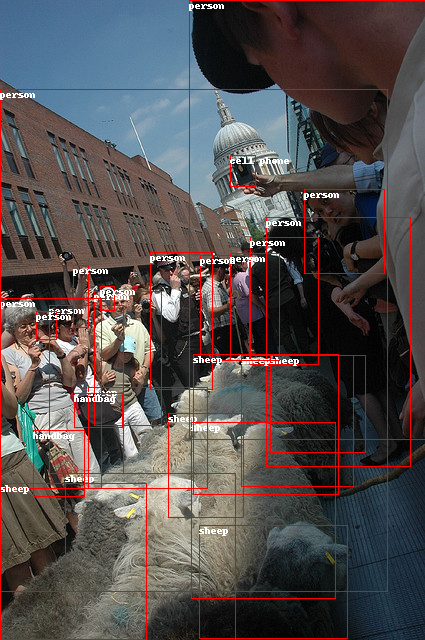

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw


image_ids = test_dataset.coco.getImgIds()

image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/drive/MyDrive/road-damage-detection/detr-resnet50/val2017', image['file_name']))

annotations = test_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = test_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

# Create a test dataloader
Since the feature extractor takes in images of a minimum size of 800 and a max size of 1333, we batch the images.

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=2)

## Sanity check

In [9]:
batch = next(iter(test_dataloader))
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [10]:
batch['pixel_values'].shape

torch.Size([2, 3, 873, 1201])

In [11]:
batch['pixel_mask'].shape

torch.Size([2, 873, 1201])

# Evaluate model

In [12]:
%cd /content/drive/MyDrive/road-damage-detection/detr-resnet50

/content/drive/MyDrive/road-damage-detection/detr-resnet50


In [ ]:
!git clone https://github.com/facebookresearch/detr.git

In [13]:
%cd detr/

/content/drive/MyDrive/road-damage-detection/detr-resnet50/detr


## Initialize CocoEvaluator

In [14]:
from datasets import get_coco_api_from_dataset 
from datasets.coco_eval import CocoEvaluator

base_ds = get_coco_api_from_dataset(test_dataset)
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) 

In [15]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [18]:
from tqdm.notebook import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

print("Running evaluation...")

nbatches = 2500

for idx, batch in enumerate(tqdm(test_dataloader)):
    
    if idx > nbatches:
        break
    
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] 

    # forward pass
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

Running evaluation...


  0%|          | 0/2500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/detr/modeling_detr.py:422: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


In [19]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=10.40s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.333
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= l